# Linguistic Harbinger of Fake News - Paper Extension

In this extension, our goal is to explore whether the linguistic cues found in the original paper are suitable for a descriptive/predictive analysis in the context of fake news recognition.

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
import nltk.data
import re
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from discourseMarkers import rule
from nltk import word_tokenize
from nltk import sentiment
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.parse.corenlp import CoreNLPParser
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from resources import lemmatizer, premise_conclusion_markers, english_dictionary, wordnet

# Create and register a new `tqdm` instance with `pandas`
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/tqd

### Step 0: the dataset

The dataset that we are using in the following analysis has been downloaded from Kaggle at this [link](https://www.kaggle.com/jruvika/fake-news-detection).
It is composed by 4009 entries of real of fake articles about different topics. Each entry specifies the source URLs of the article, its title, its body and a label that is 0 in case the news is fake and 1 otherwise.

The dataset contains some articles with empty body. We decided to discard such articles since none of the features that we try to identify is meaningful if computed by using the title only.

Note that even though the dataset contains the source URLs of the articles, they will not be used on purpose in the following analysis: our intention is to explore linguistic cues that characterize deception, not to distinguish trustworthy from untrustworty websites.

In [2]:
data_raw = pd.read_csv("data/data.csv")
data = data_raw.copy(deep = True).dropna().reset_index(drop=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3988 entries, 0 to 3987
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      3988 non-null   object
 1   Headline  3988 non-null   object
 2   Body      3988 non-null   object
 3   Label     3988 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 124.8+ KB


### Step 1: Preprocessing and Feature Extraction 

Both preprocessing and feature extraction are performed by the same function: extract_linguisic_features, which first cleans the dataset and then applies the feature extractors. 

The first cleaning is very simple, since some of the feature extractors require the sentences to be plain text. Indeed, the only operation applied to all the sentences in the dataset has been to swap fullstop and ending quotes whenever they were found in the wrong order at the end of quoted sentence. Many times we were able to recognise the pattern '.”' in the articles; however, the correct order is: '”.'. This was a problem when we tried to split an artilce in subsentences. nltk's sentence tokenizer, in fact, does not recognize the end of a sentence all the times the mentioned pattern occurs.

The features that we will try to identify for each article are the following ones:
 - number_of_sentences: number of sentences in the article, first split the article into sentences and then count them;
 - number_of_words: number of word tokens in the article (special characters, that are usually considered tokens by the nltk tokenizer, are discarded);
 - average_sentence_lenght: average lenght of the article's sentences, to compute it divide the total number of words by the number of sentences in the article
 - average_word_lenght: average lenght of words in the article, computed by averaging the lenghts words in the article;
 - nltk_sentiment: numerical value that describes the sentiment of the article, computed using the Sentiment Intensity Analyzer by nltk;
 - subjectivity: numerical value that describes how much the article is subjective, computing using TextBlob;
 - number_of_premise_conclusion_markers: number of premise or conclusion markers in the article, computed by looking for specific markers taken from an handcrafted lexicon which takes ispiration form this online [resource](https://academic.csuohio.edu/polen/LC9_Help/1/11pcindicators.htm);
 - dictionary_percentage: percentage of words in the article that exist on the english dictionary in their lemmatized form, computed by first lemmatizing word tokens in the article, then searching them on the dictionary, and then take the percentage of them which is present on the vocabulary;
 - number_of_discourse_markers: number of argumentation/discourse markers of the article, computed by running a python script (that you can find in this folder) named discourse_markers.py, which requires the parse tree sentence representation given by Stanford parser.  
 
#TODO: Try dl

In [4]:
# TODO Comment + can we directly pass sentences as argument?
def nltk_sentiment(text):
    score_compound = []
    sid = SentimentIntensityAnalyzer()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    try:
        sentences = tokenizer.tokenize(text)
    except:
        print(text)
    for sentence in sentences:
        scores = sid.polarity_scores(sentence)
        score_compound.append(scores['compound'])

    return np.mean(score_compound)

In [5]:
def subjectivity_score(text):
    ''' Compute the subjectivity score of the text '''
    return TextBlob(text).sentiment[1]

In [6]:
def invert_quotes_fullstop(sentence):
    ''' Substitute all the patterns '.”' with '”.' in the sentence '''
    return sentence.replace('.”', '”.')

In [7]:
def split_sentences(text):
    ''' Split the text in its sub-sentences and return them as a list '''
    sentences = []
    # Split paragraphs on new line
    for period in text.split("\n"):
        # Further split paragraphs in sentences using nltk sentence tokenizer
        for sentence in sent_tokenize(period):
            sentences.append(sentence)
    return sentences

In [8]:
def count_future_verbs(sentence): 
    ''' Count the number of future tenses in the sentence '''
    future_patterns = ['will', '\'ll', 'going to']
    return np.sum([sentence.count(substring) for substring in future_patterns])

In [9]:
def count_premise_conclusion_markers(sentence):  
    ''' Count the number of premise and conclusion markers in the sentence'''
    counter = 0
    # Look for markers in the hand-crafted lexicon
    for marker in premise_conclusion_markers:
        if sentence.find(marker) != -1:
            counter += 1
    return counter

In [10]:
def get_wordnet_pos(treebank_tag):
    '''
    Helper function to convert a POS tag from the Penn Treebank to a WordNet format
    :param treebank_tag: Penn Treebank POS tag, string
    :returns: WordNet POS tag
    '''

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
def lemmatize_words(words):
    '''
    Function to lemmatize word tokens using the WordNet lemmatizer
    :param words: list of word tokens in the tweet
    :returns: list of lemmatized word tokens
    '''

    lemmatized_words = []
    # Get the Penn Treebank POS tags for the word tokens
    word_pos_tags = pos_tag(words)
    for word, word_pos_tag in word_pos_tags:
        # Get the WordNet POS tag
        word_pos_tag = get_wordnet_pos(word_pos_tag)
        # Use the WordNet POS tag to lemmatize the word into the correct word form
        lemmatized_words.append(lemmatizer.lemmatize(word, word_pos_tag))
    return lemmatized_words

In [12]:
def get_word_tokens(sentence):
    '''
    Function to retrieve only tokens corresponding to words (sequence of alphabetic characters)
    :param sentence: string corresponding to an English sentence
    :returns: parsed list of tokens with only word tokens
    '''
    tokens = word_tokenize(sentence)
    return [token for token in tokens if re.match(r"^[A-Za-z\']+$", token)]

In [13]:
def parse_tree(sentence):
    ''' 
    Create the parse tree for the given sentence 
    :param sentence: plain English sentence
    :returns: nltk.Tree parse tree of the sentence
    '''
    parser = CoreNLPParser()
    return next(parser.raw_parse(sentence))

In [14]:
def percentage_words_in_dict(words):
    ''' 
    Computes the percentage of words in words present on the English dictionary
    :param words: list of words
    :returns: percentage of words in words on the dictionary in their lemmatized form
    '''
    # Fill this list with the words whose lemma can be found on English dictionary
    dictionary_words = [word for word in lemmatize_words(words) if word in english_dictionary]
    num_dictionary_words = len(dictionary_words)
    num_words = len(words)
    dictionary_percentage = num_dictionary_words / num_words if num_words > 0 else 0
    return dictionary_percentage

In [15]:
def extract_linguisic_features(text):
    ''' 
    Clean the text and then extract all the mentioned linguistic features from it,
    organize them in a dictionary and return it
    :param text: plain article text as a string
    :returns: dictionary containing all the features of the given text  
    '''
    
    features = dict()
    
    clean_text = invert_quotes_fullstop(text)
    
    sentences = split_sentences(clean_text)
    words = get_word_tokens(clean_text)
    
    # Compute the total number of sentences
    num_sentences = len(sentences)
    features['number_of_sentences'] = num_sentences
    
    # Compute the number of words in the text
    num_words = len(words)
    features['number_of_words'] = num_words
    
    # Compute the average lenght of text's sentences
    features['average_sentence_lenght'] = num_words / num_sentences 
    
    # Compute the average lenght of the words in the text
    features['average_word_lenght'] = np.mean([len(w) for w in words])
    
    # Compute the sentiment of the text
    features['nltk_sentiment'] = nltk_sentiment(clean_text)
    
    # data['bert_sentment'] = data.Body.apply(bert_sentiment)
    features['subjectivity'] = subjectivity_score(clean_text)
    
    # Compute the number of verbs at future tense
    features['number_of_future_verbs'] = count_future_verbs(clean_text)
    
    # Compute the number of premise and conclusion markers
    features['number_of_premise_conclusion_markers'] = count_premise_conclusion_markers(clean_text)
    
    # Compute the proportion of words belonging to the dictionary
    features['dictionary_percentage'] = percentage_words_in_dict(words)
    
    return features

The following cell has to be run only the first time. After that, the features' dataframe will be stored in a proper csv file and from that moment it can be instantly loaded by reading the csv.

In [16]:
try: 
    # Load the features' dataframe from the csv file if present
    features_df = pd.read_csv("data/features.csv") 

except FileNotFoundError:
    
    # Extract features from each article and put them in a dataframe
    features_df = data.progress_apply(lambda x: pd.Series(extract_linguisic_features(x.Body)), axis=1)

    # Load the pre-computed discourse markers list
    with open('discourseMarkers.data', 'rb') as filehandle:
        # read the data as binary data stream
        discourse_markers = pickle.load(filehandle)

    # Add a new column to the features dataframe 
    # containing the number of discourse markers for each article
    features_df['number_of_discourse_markers'] = pd.Series([len(l) for l in discourse_markers])

    # Store the dataframe 
    features_df.to_csv("data/features.csv", index=False)

100%|██████████| 3988/3988 [03:11<00:00, 20.82it/s]


In [17]:
# Merge the original dataframe with the new features
extended_df = data.merge(features_df, right_index=True, left_index=True)

In [18]:
extended_df.head(1)

,URLs,Headline,Body,Label,number_of_sentences,number_of_words,average_sentence_lenght,average_word_lenght,nltk_sentiment,subjectivity,number_of_future_verbs,number_of_premise_conclusion_markers,dictionary_percentage,number_of_discourse_markers
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,56.0,1081.0,19.303571,4.719704,-0.055431,0.45786,6.0,4.0,0.823312,47


### Step 2: Regression

TODO: add textual description

In [19]:
features = list(features_df.columns)
labels = ['Label']
X = extended_df[features]
y = extended_df[labels]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [21]:
logit_model = sm.Logit(y_train,X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.522145
         Iterations 7
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.245      
Dependent Variable:        Label                  AIC:                    2934.6132  
Date:                      2020-12-18 04:00       BIC:                    2993.9547  
No. Observations:          2791                   Log-Likelihood:         -1457.3    
Df Model:                  9                      LL-Null:                -1929.1    
Df Residuals:              2781                   LLR p-value:            2.5435e-197
Converged:                 1.0000                 Scale:                  1.0000     
No. Iterations:            7.0000                                                    
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z     P>|z|   [0.

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


In [24]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.82      0.63      0.71       637\n           1       0.66      0.84      0.74       560\n\n    accuracy                           0.73      1197\n   macro avg       0.74      0.73      0.73      1197\nweighted avg       0.75      0.73      0.72      1197\n'

### Step 3: Visualization

For the visualization part, we want to make as clear as possible which of the individuated features has an effect on the label and which does not. To do that, we drew multiple categorical plot comparing the features' distributions in the fake news and in the actual articles.

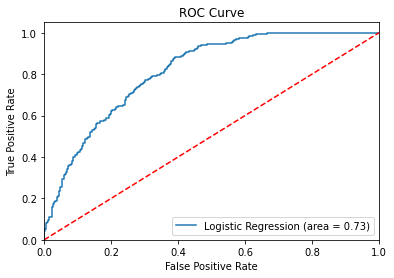

In [25]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [28]:
features_df.columns

Index(['number_of_sentences', 'number_of_words', 'average_sentence_lenght',
       'average_word_lenght', 'nltk_sentiment', 'subjectivity',
       'number_of_future_verbs', 'number_of_premise_conclusion_markers',
       'dictionary_percentage', 'number_of_discourse_markers'],
      dtype='object')

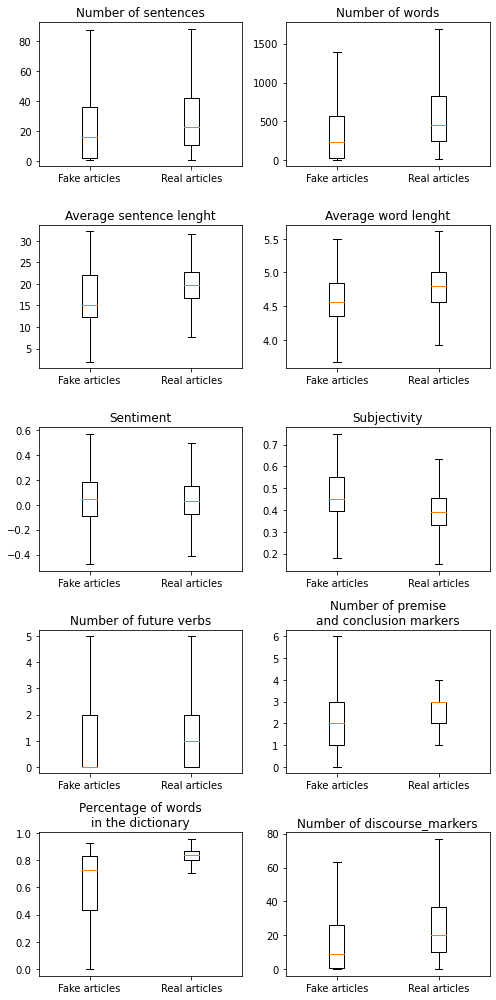

In [29]:
# Draw a boxplot for each feature comparing real and fake news' distributions of the feature

titles = ['Number of sentences', 'Number of words', 'Average sentence lenght',
       'Average word lenght', 'Sentiment', 'Subjectivity', 'Number of future verbs',
       'Number of premise\nand conclusion markers', 'Percentage of words\nin the dictionary',
       'Number of discourse_markers']

fig, axs = plt.subplots(5, 2, figsize=(7,14))

for idx, feature in enumerate(features_df.columns):
    axs[idx//2][idx%2].boxplot(x=[extended_df[extended_df.Label == 0][feature], 
              extended_df[extended_df.Label == 1][feature]], 
              bootstrap=1000, labels=['Fake articles', 'Real articles'], showfliers=False)
    axs[idx//2][idx%2].set_title(titles[idx])
    
fig.tight_layout()

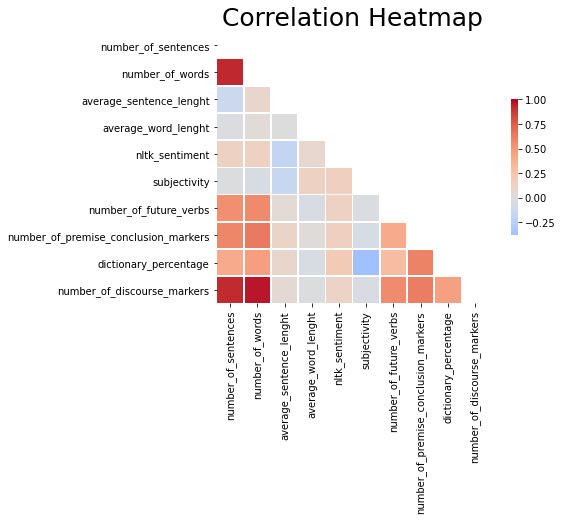

In [30]:
# Computing the Correlation Matrix
spike_cols = [col for col in features_df.columns]
corr = features_df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 15, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")